<a href="https://colab.research.google.com/github/dddddyoung2/Spotify-Popularity-Prediction/blob/main/Spotify_Popularity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Popularity Prediction
- section 2 Project

## 필요한 라이브러리 설치

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install catboost
    !pip install PDPbox
    !pip install shap
    !pip install tqdm
    !pip install kaggle

In [2]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 
#warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import shap

## 데이터 선정 이유 및 문제 정의
- 음악의 인기도에 다양한 변수들의 영향을 받을 것으로 판단
 - 예를 들면, 아티스트의 인기도나 뮤직비디오 또는 다양한 홍보 방식에 의한 효과 등

- 선정 이유
 - 그런 변수들을 제외하고, 음악의 오디오 특성만으로 인기도를 예측할 수 있을 지 궁금해짐
 
- 문제 정의 : 음악의 오디오(음악적 요소) 특성에 따라 Popularity(인기도) 예측
1. 역대 인기도 합산 1위 아티스트?
2. 인기도가 높은 곡의 오디오 특성?
3. 인기도에 가장 영향을 많이 미치는 음악적 요소는?
4. (인기도는 곧 대중성을 의미한다고 판단한다면, 대중성 있는 곡의 특징은 무엇일까?)

- 기대 효과
 - 곡 발매 전, 인기도 테스트를 시도해볼 수 있음
   - 스포티파이 오디오 특성 기준처럼 측정할 수 있는 도구 필요
 - 작곡가가 대중성 있는 곡을 만든다고 할 때 베이스라인이 될 수 있음

## Dataset
 - 전 세계 1위 음악 스트리밍 플랫폼 Spotify (약 1억 9100만명 사용 중(확인하기))의 음악 데이터
 - Spotify 웹 API를 통해 1921년부터 2020년까지의 약 170,000곡 이상의 음악 데이터로 2020년 6월 kaggle 업로드 됨 by Yamaç Eren Ay
  - 모든 음악이 있는 것은 아님

- target: 
 - popularity (Ranges from 0 to 100) : 곡의 인기도
 -인기는 알고리즘에 의해 계산되며 대부분의 경우 트랙의 총 재생 수와 이러한 재생의 최근 수를 기반으로 한다. 일반적으로 지금 많이 재생되고 있는 노래는 과거에 많이 재생되었던 노래보다 높은 인기를 얻게 된다.(한계이기도 함..)
- 접근 방식: 회귀
- 평가 지표: MAE, MSE, R2, RMSE 등


### Data Description

인기도(목표변수)
- popularity (Ranges from 0 to 100)



잔잔하고 클래식한 음악적 요소들
- acousticness (Ranges from 0 to 1)
- instrumentalness (Ranges from 0 to 1)

활기찬 음악적 요소들
- danceability (Ranges from 0 to 1) : 춤 추기 적합한 정도
- energy (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- tempo (Float typically ranging from 50 to 150)
- loudness (Float typically ranging from -60 to 0)

재생 시간
- duration_ms (Integer typically ranging from 200k to 300k)

기타 음악적 요소들
- liveness (Ranges from 0 to 1)
- speechiness (Ranges from 0 to 1)
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…): 음의 높낮이

Dummy:
- mode (0 = Minor, 1 = Major)
- explicit (0 = No explicit content, 1 = Explicit content(선정적)

발매일
- release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)

트랙 고유 요소들
- artists
- id (Id of track generated by Spotify)
- name (Name of the song)






(부연 설명)
- Instrumentalness :이 값은 노래의 보컬 양을 나타냅니다. 1.0에 가까울수록 노래가 더 음악적입니다.
- Acousticness :이 값은 노래의 어쿠스틱 정도를 나타냅니다. 1.0 점은 노래가 음향적일 가능성이 가장 높다는 것을 의미합니다.
- Liveness :이 값은 라이브 청중과 함께 노래가 녹음되었을 확률을 나타냅니다. 공식 문서에 따르면 " 0.8보다 큰 값은 트랙이 라이브 일 가능성이 큽니다" .
- Speechiness : " Speechiness는 트랙에서 말한 단어의 존재를 감지합니다 ." 노래의 발화도가 0.66 이상이면 말로 구성되었을 가능성이 높습니다. 0.33에서 0.66 사이의 점수는 음악과 단어를 모두 포함 할 수있는 노래이며 0.33 미만의 점수는 노래에 음성이 없음을 의미합니다.
- 에너지 : " (에너지)는 강도와 활동의 지각 적 측정을 나타냅니다. 일반적으로 활기찬 트랙은 빠르고 시끄럽고 시끄 럽습니다 .”
- Danceability :“ Danceability는 템포, 리듬 안정성, 비트 강도 및 전반적인 규칙 성을 포함한 음악적 요소의 조합을 기반으로 트랙이 춤에 얼마나 적합한 지 설명합니다. 0.0 값은 춤을 추기 어렵고 1.0은 춤을 추기 쉽습니다 .
- Valence : " 트랙이 전달하는 음악적 긍정적 인 정도를 설명하는 0.0에서 1.0 사이의 측정 값입니다. 가가 높은 트랙은 더 긍정적으로 들리며 (예 : 행복, 쾌활함, 행복감), 반면에 가가 낮은 트랙은 더 부정적인 소리 (예 : 슬프다, 우울함, 화가 난다) ”.

##  데이터 불러오기
- 코랩-캐글 연동

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dddddyoung2","key":"00016a52556940ed22cdc71767614579"}'}

In [4]:
ls -1ha kaggle.json #파일 업로드 확인

kaggle.json


In [5]:
#json 파일 이동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 내가 참가한 대회 리스트 확인
#!kaggle competitions list

In [6]:
# 캐글 데이터 주소 복사
! kaggle datasets download -d yamaerenay/spotify-dataset-19212020-160k-tracks

 95% 185M/195M [00:03<00:00, 42.3MB/s]
100% 195M/195M [00:03<00:00, 58.9MB/s]


In [7]:
!Is

/bin/bash: Is: command not found


In [8]:
!unzip spotify-dataset-19212020-160k-tracks.zip

Archive:  spotify-dataset-19212020-160k-tracks.zip
  inflating: artists.csv             
  inflating: data_by_artist_o.csv    
  inflating: data_by_genres_o.csv    
  inflating: data_by_year_o.csv      
  inflating: data_o.csv              
  inflating: dict_artists.json       
  inflating: tracks.csv              


In [9]:
data = pd.read_csv('./data_o.csv')
data.head(3)

valence  year  acousticness  ... release_date  speechiness    tempo
0   0.0594  1921         0.982  ...         1921       0.0366   80.954
1   0.9630  1921         0.732  ...         1921       0.4150   60.936
2   0.0394  1921         0.961  ...         1921       0.0339  110.339

[3 rows x 19 columns]

In [10]:
data.shape

(170653, 19)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [12]:
data.describe(include = 'all')

valence           year  ...    speechiness          tempo
count   170653.000000  170653.000000  ...  170653.000000  170653.000000
unique            NaN            NaN  ...            NaN            NaN
top               NaN            NaN  ...            NaN            NaN
freq              NaN            NaN  ...            NaN            NaN
mean         0.528587    1976.787241  ...       0.098393     116.861590
std          0.263171      25.917853  ...       0.162740      30.708533
min          0.000000    1921.000000  ...       0.000000       0.000000
25%          0.317000    1956.000000  ...       0.034900      93.421000
50%          0.540000    1977.000000  ...       0.045000     114.729000
75%          0.747000    1999.000000  ...       0.075600     135.537000
max          1.000000    2020.000000  ...       0.970000     243.507000

[11 rows x 19 columns]



---



## 기준모델(Baseline Model)
 - 회귀 문제: 타겟의 평균값

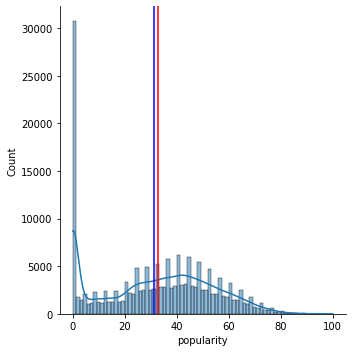

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

## target의 확률밀도함수
sns.displot(data['popularity'], kde=True)

## 평균과, 중간값으로 수직선을 그려보겠습니다.
plt.axvline(data['popularity'].mean(), color='blue')
plt.axvline(data['popularity'].median(), color='red');

- popularity가 0 값에 몰려있음
- 평균과 중위수는 별 차이 안남 31~32

In [14]:
#기준모델 평가지표

#label 정의
target=data['popularity']

#평균으로 예측
predict=target.mean()
print('Target mean: ', round(predict, 4))

# 기준모델로 에러(MAE) 계산
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

pred = [predict] * len(target)
mae = mean_absolute_error(target, pred)
print('MAE: ', round(mae, 4))

mse=mean_squared_error(target, pred)
print('MSE: ', round(mse, 4))
print('RMSE: ', round(np.sqrt(mse),4))


#r제곱
r2 = r2_score(target, pred)
print('R2:', r2)

Target mean:  31.4318
MAE:  18.4979
MSE:  476.3983
RMSE:  21.8266
R2: 0.0


- 예측한 popularity가 31.43이며, 절대평균에러가 18.50 것을 확인할 수 있음
- 베이스라인을 확인했으니, 데이터의 탐색 및 가공 시작



---



## Cleaning

### feature
- drop columns
 - id/name: 고유값으로 모델을 만드는 데 불필요한 컬럼(High Cardinality)
 - year/ release_date : 동일한 값을 가진 피처로 'release_date'을 삭제함

- think
 - Artists : high cardinality이며 곡의 인기도에 영향을 미칠 것으로 예상됨. 별도 처리 필요

In [15]:
len(data['id'].value_counts())

170653

In [16]:
len(data['name'].value_counts())

133638

In [17]:
data['artists'].head(3)

0    ['Sergei Rachmaninoff', 'James Levine', 'Berli...
1                                       ['Dennis Day']
2    ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...
Name: artists, dtype: object

In [18]:
#동일한 특성
print(data['release_date'].head(3))

print(data['year'].head(3))

0    1921
1    1921
2    1921
Name: release_date, dtype: object
0    1921
1    1921
2    1921
Name: year, dtype: int64


In [348]:
#feature drop
df = data.drop(['id', 'name', 'release_date'], axis=1)
df.shape

(170653, 16)

### 중복값, 결측치 확인

In [349]:
#결측치 있는 특성 확인 함수
[(x, df[x].isnull().sum()) for x in df.columns if df[x].isnull().any()]

[]

- 결측치가 없는 것을 확인

In [350]:
# 중복값 제거
df.drop_duplicates(inplace=True)

In [351]:
df.shape

(170025, 16)



---



## EDA / 피처 엔지니어링

In [23]:
df.describe()

valence           year  ...    speechiness          tempo
count  170025.000000  170025.000000  ...  170025.000000  170025.000000
mean        0.529215    1976.888211  ...       0.098534     116.898815
std         0.262955      25.868728  ...       0.162983      30.698763
min         0.000000    1921.000000  ...       0.000000       0.000000
25%         0.318000    1956.000000  ...       0.034900      93.479000
50%         0.540000    1978.000000  ...       0.045000     114.774000
75%         0.747000    1999.000000  ...       0.075700     135.573000
max         1.000000    2020.000000  ...       0.970000     243.507000

[8 rows x 15 columns]

### Categorical Features

1. artists
2. explicit
3. key
4. mode

In [25]:
len(df['artists'].value_counts())

34088

#### Artists

- 역대 인기도를 합했을 때, 어떤 Artist가 1위일까?
 - 1920~2020년 인기도 합산 결과

In [26]:
#song_10 = data(['name'])

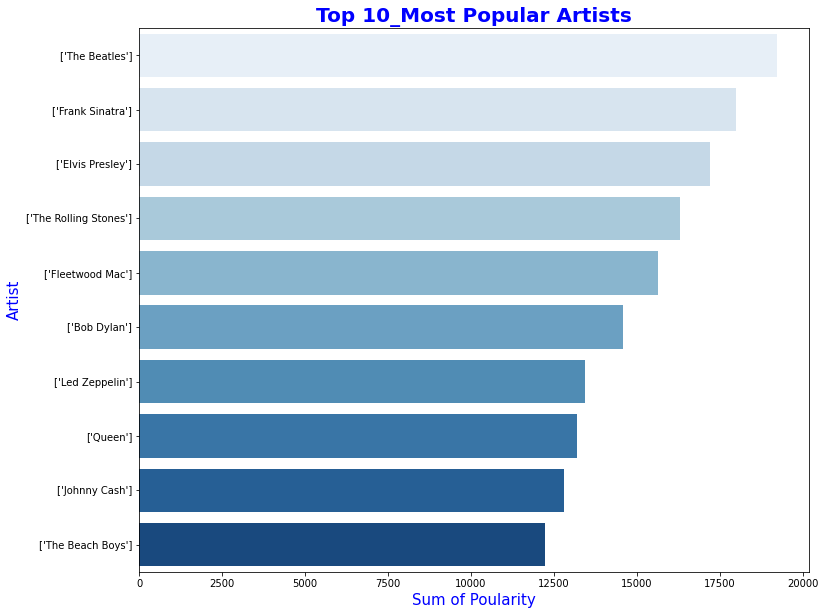

In [329]:
#막대그래프 시각화

artists_10 = df.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize = (12, 10))
ax = sns.barplot(x=artists_10.values, y=artists_10.index, palette='Blues', orient='h', ax=ax)
ax.set_xlabel('Sum of Poularity', c='b', fontsize=15)
ax.set_ylabel('Artist', c='b', fontsize=15)
ax.set_title('Top 10_Most Popular Artists', c='b', fontsize=20, weight ='bold')

plt.savefig('top 10 artist.png')
plt.show()

- popularity 합산 결과, The Beatles 1위, Frank Sinatra 2위 등등

질문
- 높은 popularity를 가진 아티스트는 데이터에 포함된 곡 수가 많기 때문이다?
 - 데이터셋 내에서 아티스트의 곡이 포함된 수를 알아보아야 함
 - 아티스트가 데이터에 포함된 수와 popularity 의 상관관계를 확인해야함
 - poupuarity 평균으로 비교
 - ☆이때, 어떤 아티스트인지 분류하면 안됨 인기에 영향을 줄 수 있기 때문에☆


In [108]:
#feature engineering
df['count'] = df.groupby('artists')['popularity'].transform('count') #곡별로 아티스트에 해당하는 값 대입
df['mean'] = df.groupby('artists')['popularity'].transform('mean')

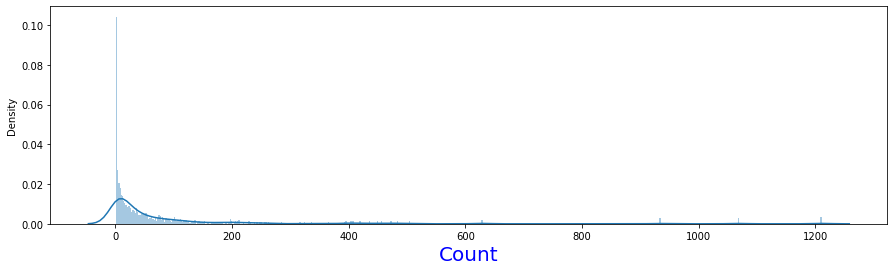

In [330]:
#count 히스토그램
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df['count'], bins = 600)
ax.set_xlabel('Count', fontsize=20, c='b')

plt.savefig('count_hist.png')
plt.show()

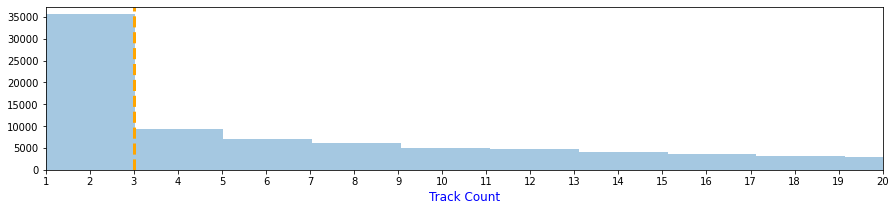

In [333]:
#데이터에 포함된 아티스트별 곡 수

fig, ax = plt.subplots(figsize = (15, 3))
ax = sns.distplot(df['count'], bins=600, kde=False) #600개 이상으로 cut(1200의 반)
ax.set_xlabel('Track Count', fontsize=12, c='b')

ax.set_xlim(1,20)
ax.set_xticks(range(1,21,1)) #간격 지정
ax.axvline(x=3, ymin=0, ymax=1, color='orange', linestyle='dashed', linewidth=3)

#ax.annotate("", xy=(3, 19000), xytext=(4.8, 19000), arrowprops=dict(arrowstyle="->", color='r', linestyle='dashed', linewidth=3)) #화살표
#ax.text(x = 5, y = 19000, s='cutoff = 3', fontdict=font) #표에 글자 넣기
plt.savefig('count.png')
plt.show()

- 데이터에 포함된 아티스트별 곡 수는 대체적으로 3에 몰려 있는 것을 볼 수 있음 

In [31]:
# 발매곡 수 별 popularity 평균 데이터 프레임 만들기
scatter = df.groupby('count')['mean'].mean().to_frame().reset_index()
scatter

count       mean
0        1  36.537625
1        2  34.352116
2        3  33.148592
3        4  32.694188
4        5  34.129001
..     ...        ...
204    628   0.031847
205    630  28.550794
206    934   0.059957
207   1068   0.000000
208   1211   0.066061

[209 rows x 2 columns]

In [32]:
scatter['mean'].describe()

count    209.000000
mean      29.841647
std       11.843958
min        0.000000
25%       26.490431
50%       32.095789
75%       37.356614
max       58.845411
Name: mean, dtype: float64

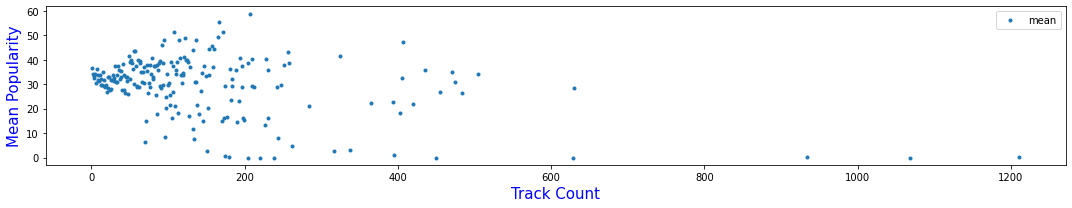

In [334]:
#산점도 그래프
fig, ax = plt.subplots(figsize = (15, 3))
ax = scatter.plot(x='count', y='mean', marker='.', linestyle= '', ax=ax) #점으로 표현
ax.set_xlabel('Track Count', fontsize=15, c='b')
ax.set_ylabel('Mean Popularity', fontsize=15, c='b')
plt.tight_layout()
plt.savefig('count_mean.png')
plt.show()

- 데이터에 포함된 곡 수가 많다고 Popularity 가 높은 것이 아님을 알 수 있음
 - ex) 발매 곡 수가 1200임에도 평균 Popularity가 낮음

In [34]:
#발매곡 수 > 900 의 Popularity
m_count=df[['mean']].loc[df['count']>900].value_counts(ascending=False).reset_index()
m_count.columns=['Mean popularity', 'track count']
m_count

Mean popularity  track count
0         0.066061         1211
1         0.000000         1068
2         0.059957          934

??
따라서 이 기능을 처리하기 위해 다음과 같이 '아티스트' 기능을 객체에서 부동 값으로 변환하는 변압기를 사용할 것이다.

데이터를 아티스트로 대체하면 인기를 의미합니다.

아티스트가 최소 시간보다 적게 나타나는 값을 인기 평균으로 대체

아티스트가 최대 횟수보다 많이 나타나는 값을 0으로 바꾸기

#### Mode
- Major:1
- Minor: 0

In [35]:
df['mode'].value_counts()

1    120219
0     49806
Name: mode, dtype: int64

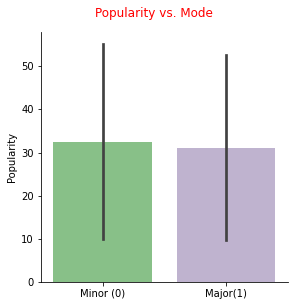

In [36]:
exp_data = sns.catplot(data=df, kind="bar",
                        x="mode", y="popularity",
                        ci="sd", palette='Accent',
                        height=4)
exp_data.fig.suptitle('Popularity vs. Mode', y=1.05, c='r')
exp_data.set_axis_labels("", "Popularity")
exp_data.set_xticklabels(['Minor (0)', 'Major(1)'])
plt.show()

- Major가 Minor인 음악보다 수가 약 3배 정도 차이가 나지만, 곡의 인기도에는 큰 영향이 없음

#### Key
- 0~11

In [37]:
df['key'].value_counts()

0     21529
7     20732
2     18752
9     17528
5     16372
4     12891
1     12843
10    12081
8     10711
11    10627
6      8705
3      7254
Name: key, dtype: int64

#### explicit

In [160]:
import plotly.express as px
def func(df):
    if df == 1:
        return 'Yes'
    else:
        return 'No'
df['isExplicit'] = df['explicit'].apply(func)
px.pie(data_frame = df, names = 'isExplicit', hole = 0.2, title = 'Explicit')

In [161]:
df.head(5)

valence  year  acousticness  ... count      mean  isExplicit
0   0.0594  1921         0.982  ...     2  2.500000          No
1   0.9630  1921         0.732  ...     5  3.000000          No
2   0.0394  1921         0.961  ...    21  2.428571          No
3   0.1650  1921         0.967  ...     1  3.000000          No
4   0.2530  1921         0.957  ...     3  1.333333          No

[5 rows x 19 columns]

### Numerical Features

#### 상관분석

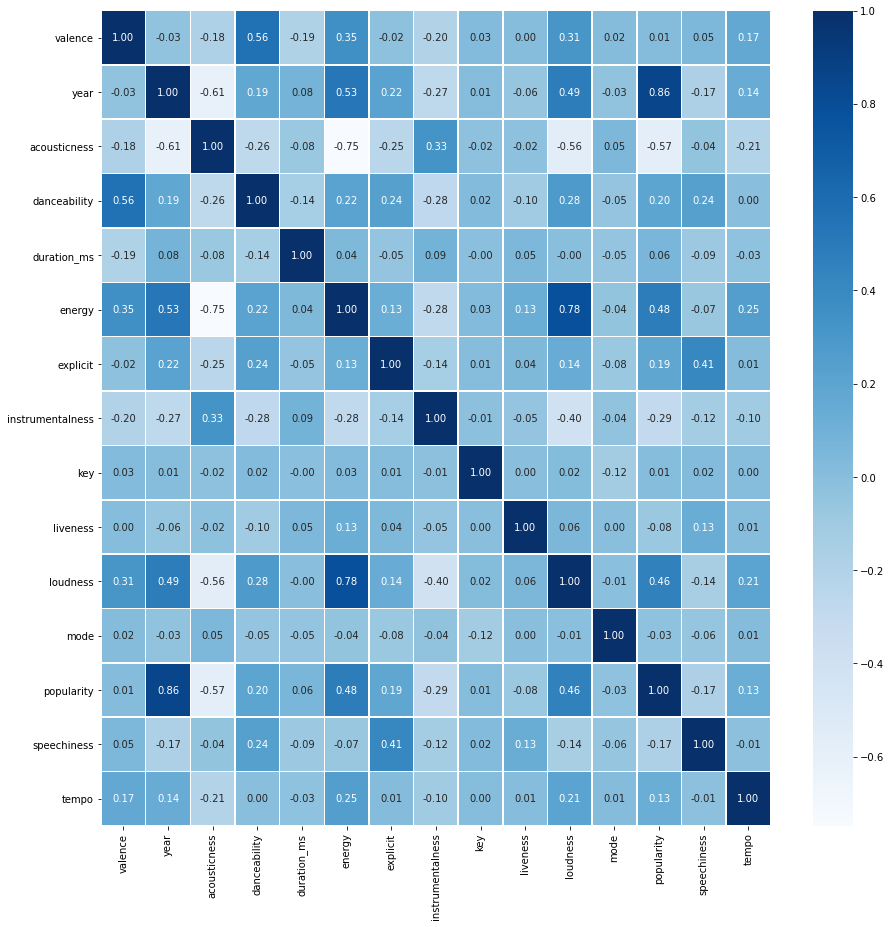

In [38]:
# 상관분석

%matplotlib inline
df_corr=df.drop(['mean', 'count'], axis=1)
plt.figure(figsize=(15,15))
sns.heatmap(data=df_corr.corr(), annot=True,
            fmt='.2f', linewidths=.5, cmap='Blues')



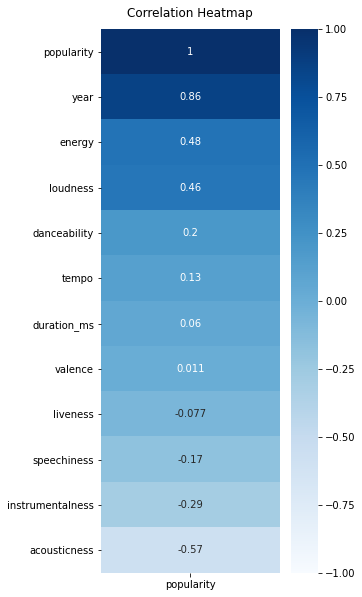

In [336]:
#상관관계 정렬
fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(df_corr.corr()[['popularity']].sort_values(by='popularity', ascending=False),
            vmin = -1, vmax = 1, annot=True, cmap="Blues")

ax.set_title('Correlation Heatmap', pad = 12)

plt.savefig('a_corr.png')
plt.show()

- 상관분석 결과, year, energy, loudness, danceability는 popularity와 양의 상관관계, acousticness, instrumentalness는 popularity와 음의 상관이 존재한다고 봄(0.2 기준)

#### 질문
- 가장 인기가 많은 곡은 어떤 오디오 특성을 가지고 있을까?
 - popularity 가 100인 곡이 딱 하나가 있음

In [41]:
#상관관계 > 0.4 인 특성
top=data[['year','artists', 'name', 'energy', 'loudness', 'danceability', 'acousticness', 'instrumentalness', 'popularity', 'speechiness']].loc[data['popularity']>=97]
top.sort_values(by='popularity')

year                       artists  ... popularity  speechiness
19618  2020                       ['BTS']  ...         97       0.0993
19606  2020     ['24kGoldn', 'iann dior']  ...         99       0.0369
19611  2020  ['Bad Bunny', 'Jhay Cortez']  ...        100       0.0544

[3 rows x 10 columns]

In [42]:
# 인기도 top 3 오디오 특성 시각화

#### 히스토그램

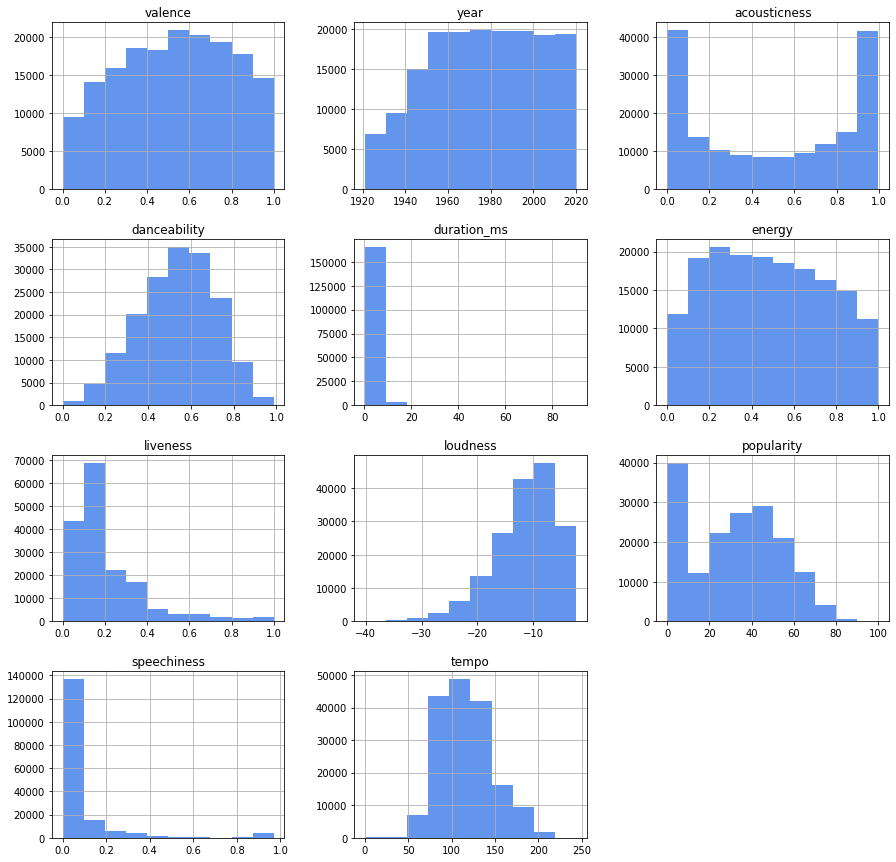

In [337]:
#히스토그램
#상관 > 0.2
df_corr=df.drop(['mean', 'count', 'explicit', 'key', 'mode'], axis=1)
df_corr.hist(figsize=(15,15), color='cornflowerblue')
plt.savefig('a_hist.png')
plt.show()


특이사항

1. acousticness : 분포가 극단적임
2. duration_ms,speeciness : 0에 몰려있음
3. instrumentalness : 분포가 고르지 않음

#### Year

In [44]:
print('taget과 year의 상관관계: ', round(df['year'].corr(df['popularity']), 2))

taget과 year의 상관관계:  0.86


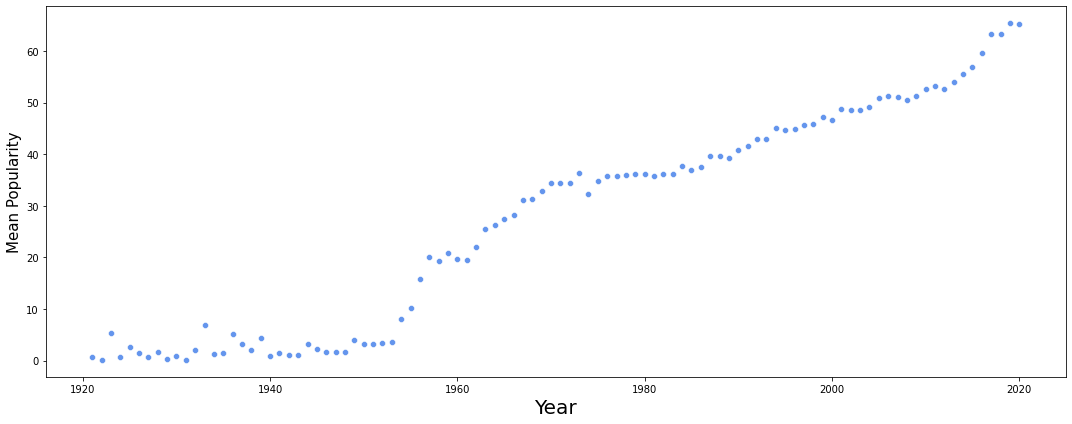

In [338]:
#year - mean popularity

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('year')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='year', y='popularity', data=ax_data, color='cornflowerblue', ax=ax)

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Mean Popularity', fontsize=15)
plt.tight_layout()
plt.savefig('a_year.png')
plt.show()

- 인사이트
 - 발매 연도가 과거라고 해서 평균 인기도가 높은 것이 아님을 알 수 있다.
 - 연도별 평균 인기도 시각화 결과, 2020년에 다가갈 수록 평균 인기도가 높아진다.
 


```
이유: 
1. 인기도는 최근의 알고리즘에 의해 계산됨(총 재생 수). 
: 그래서 일반적으로 지금 많이 재생되고 있는 노래는 과거에 많이 재생되었던 노래보다 높은 인기를 얻게 됨

2. 2000년 대에 들어오면서 음악 스트리밍 시장이 커짐 
: 이전에는 불법 다운로드, 앨범 판매 위주로 과거 발매 곡의 재생 수와 인기도를
 예측하는 알고리즘이 제대로 구축되어 있지 않았을 가능성

```
- 과거의 실제 인기도가 정확하지 않을 수도 있는..이 데이터의 한계이기도 함
- 그럼에도 데이터가 많고 연도별 인기곡의 오디오 특성들이 있기 때문에 예측 모델을 만드는데 문제가 없을 것으로 판단
- 성능 좋은 예측 모델을 만드는데 집중하기

#### Energy

In [46]:
print('taget과 energy의 상관관계: ', round(df['energy'].corr(df['popularity']), 2))

taget과 energy의 상관관계:  0.48


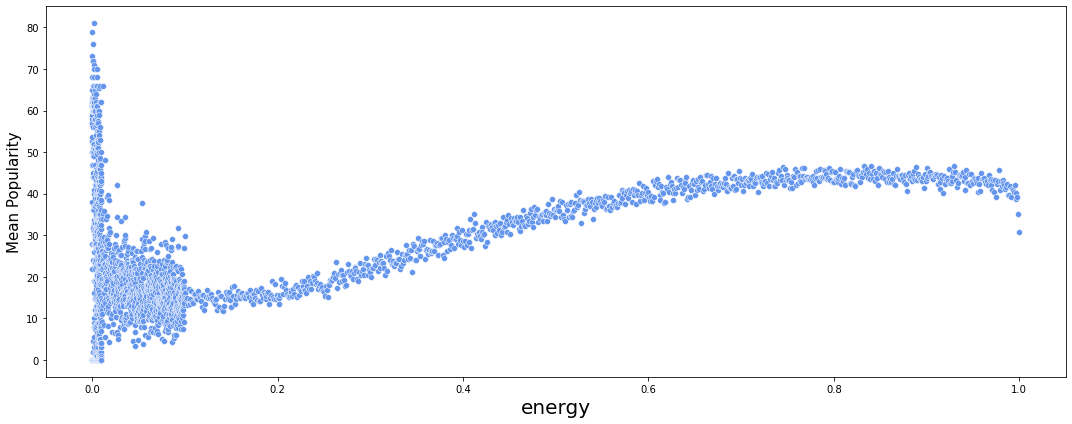

In [339]:
#energy - mean popularity

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('energy')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='energy', y='popularity', data=ax_data, color='cornflowerblue', ax=ax)

ax.set_xlabel('energy', fontsize=20)
ax.set_ylabel('Mean Popularity', fontsize=15)
plt.tight_layout()
plt.savefig('a_energy.png')
plt.show()

#### Loudness

In [48]:
print('taget과 loudness의 상관관계: ', round(df['loudness'].corr(df['popularity']), 2))

taget과 loudness의 상관관계:  0.46


In [49]:
df['loudness'].describe()

count    170025.000000
mean        -11.445250
std           5.678405
min         -60.000000
25%         -14.583000
50%         -10.564000
75%          -7.176000
max           3.855000
Name: loudness, dtype: float64

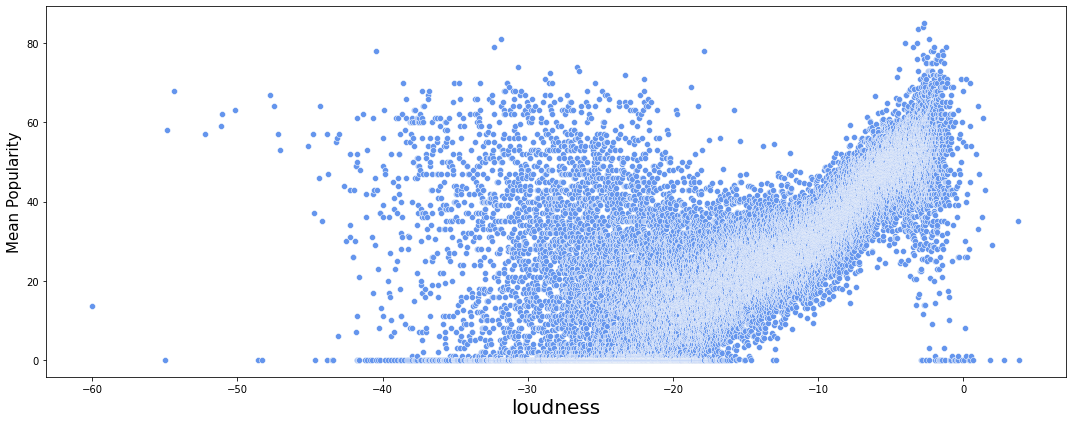

In [352]:
#loudness - mean popularity

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('loudness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='loudness', y='popularity', data=ax_data, color='cornflowerblue', ax=ax)

ax.set_xlabel('loudness', fontsize=20)
ax.set_ylabel('Mean Popularity', fontsize=15)
plt.tight_layout()

plt.show()

- 굉장히 다양함
- 구간을 나눠서 매핑이 필요할 것으로 보임

In [353]:
#이상치 제거 상위 5%, 하위 5%
df = df[(df['loudness'] >= np.percentile(df['loudness'], 0.05)) &
        (df['loudness'] <= np.percentile(df['loudness'], 99.5))]

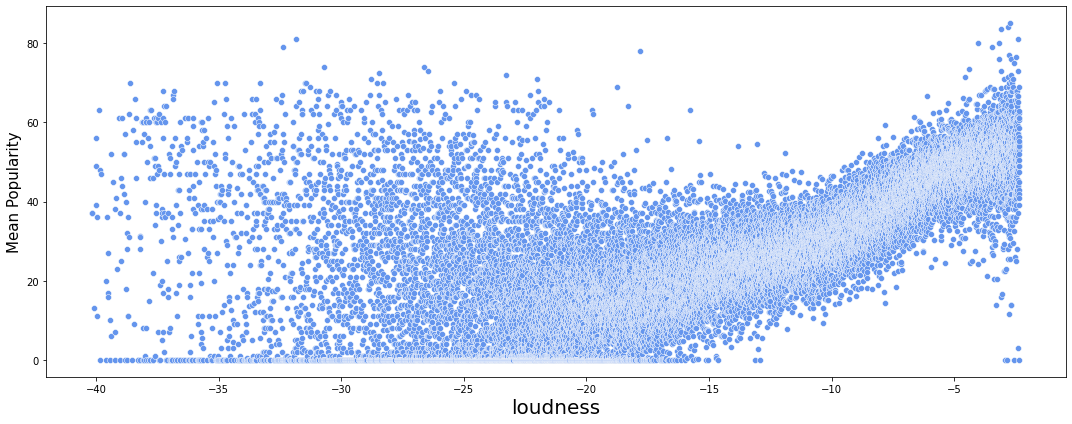

In [354]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('loudness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='loudness', y='popularity', data=ax_data, color='cornflowerblue', ax=ax)

ax.set_xlabel('loudness', fontsize=20)
ax.set_ylabel('Mean Popularity', fontsize=15)
plt.tight_layout()
plt.savefig('a_loudness2.png')
plt.show()

In [355]:
def loud(row):
    m=df['loudness'].median()
    sd=df['loudness'].std()
    if row['loudness']>=m+(1.5*sd):
        return "Extreme"
    elif row['loudness']>=m+(sd):
        return "Very Loud"
    elif row['loudness']>=m+(0.5*sd):
        return "Loud"
    elif row['loudness']>=m-(0.5*sd):
        return "Soft"
    elif row['loudness']>=m-(sd):
        return "Very Soft"
    else:
        return "Mellow"
df['is_loud']=df.apply(lambda row: loud(row), axis=1)
px.pie(data_frame = df, names = 'is_loud', hole = 0.2, title = 'IS LOUD')

In [163]:
df.head()

valence  year  acousticness  ...      mean  isExplicit    is_loud
0   0.0594  1921         0.982  ...  2.500000          No     Mellow
1   0.9630  1921         0.732  ...  3.000000          No       Soft
2   0.0394  1921         0.961  ...  2.428571          No  Very Soft
3   0.1650  1921         0.967  ...  3.000000          No       Soft
4   0.2530  1921         0.957  ...  1.333333          No       Soft

[5 rows x 20 columns]

#### Danceability

In [53]:
print('taget과 Danceability의 상관관계: ', round(df['danceability'].corr(df['popularity']), 2))

taget과 Danceability의 상관관계:  0.2


In [54]:
df['danceability'].describe()

count    169088.000000
mean          0.537908
std           0.175878
min           0.000000
25%           0.416000
50%           0.548000
75%           0.668000
max           0.988000
Name: danceability, dtype: float64

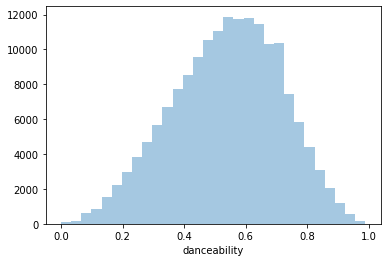

In [55]:
sns.distplot(df['danceability'],kde=False, bins=30)
plt.show()

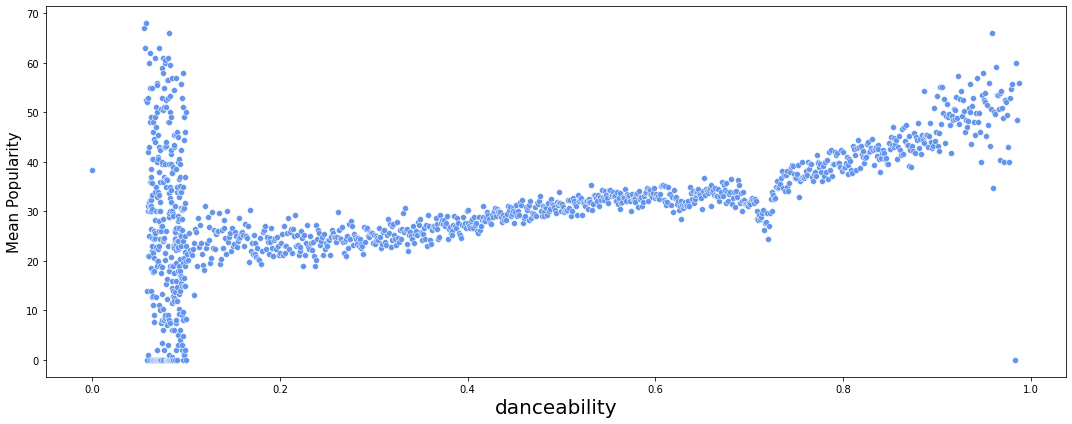

In [342]:
#danceability - mean popularity

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='danceability', y='popularity', data=ax_data, color='cornflowerblue', ax=ax)

ax.set_xlabel('danceability', fontsize=20)
ax.set_ylabel('Mean Popularity', fontsize=15)
plt.tight_layout()
plt.savefig('a_dance.png')
plt.show()

- 데이터셋에서 danceability 중간 정도의 곡이 많음
- 평균 인기도와 시각화 결과, danceability 의 정도가 높아질수록 점차 평균 인기도가 높아짐

#### Acousticness

In [59]:
print('taget과 Acousticness의 상관관계: ', round(df['acousticness'].corr(df['popularity']), 2))

taget과 Acousticness의 상관관계:  -0.57


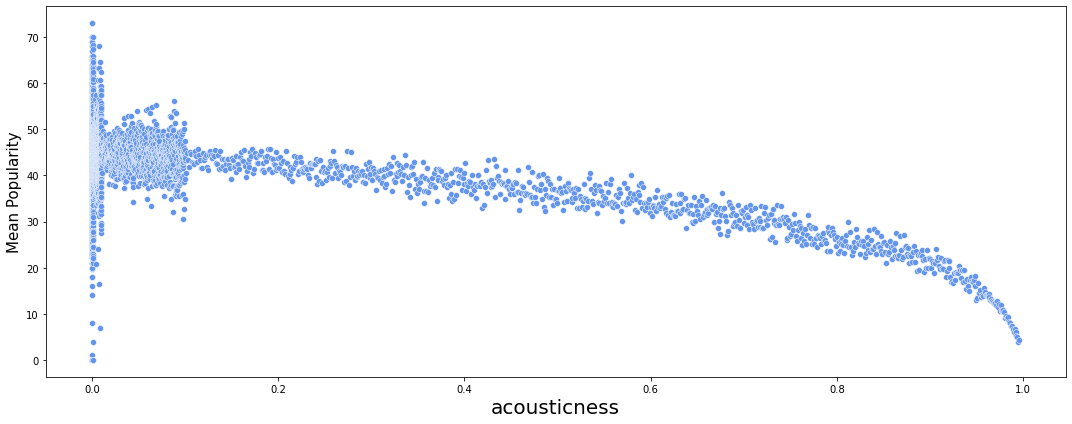

In [343]:
#Acousticness - mean popularity

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('acousticness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='acousticness', y='popularity', data=ax_data, color='cornflowerblue', ax=ax)

ax.set_xlabel('acousticness', fontsize=20)
ax.set_ylabel('Mean Popularity', fontsize=15)
plt.tight_layout()
plt.savefig('a_Acoustic.png')
plt.show()

- 인기도와 음의 관계
- energy, danceability와 반대

#### Instrumentalness

- instrumentalness(악기 연주 음악)가 1에 가까울 수록 보컬이 없는 트랙일 가능성이 있음
- 명백히 보이는 세 구간으로 나누기

In [61]:
print('taget과 Instrumentalness의 상관관계: ', round(df['instrumentalness'].corr(df['popularity']), 2))

taget과 Instrumentalness의 상관관계:  -0.29


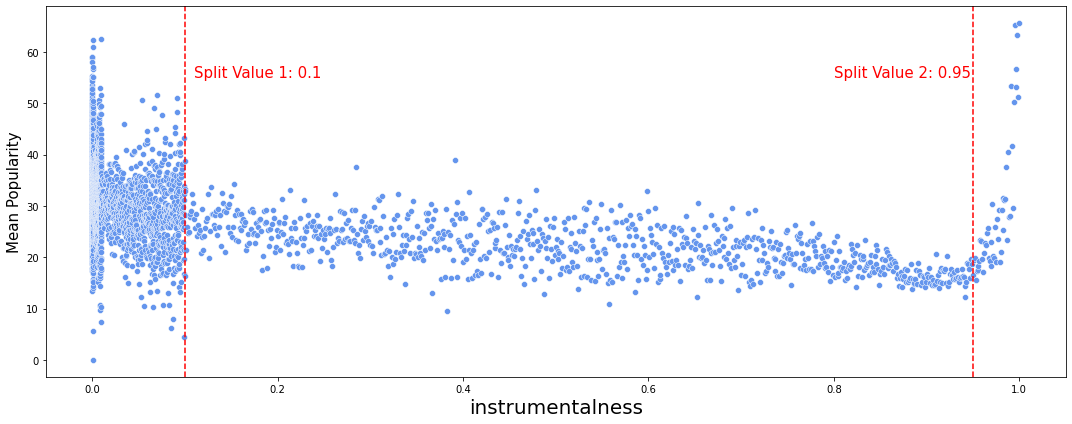

In [356]:
#instrumentalness - mean popularity

fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='instrumentalness', y='popularity', data=ax_data, color='cornflowerblue', ax=ax)

#text
ax.axvline(x=0.1, ymin=0, ymax=1, color='red', linestyle='dashed')
ax.axvline(x=0.95, ymin=0, ymax=1, color='red', linestyle='dashed')
ax.text(x = 0.11, y = 55, s='Split Value 1: 0.1', fontsize=15, c='r')
ax.text(x = 0.80, y = 55, s='Split Value 2: 0.95', fontsize=15, c='r')

ax.set_xlabel('instrumentalness', fontsize=20)
ax.set_ylabel('Mean Popularity', fontsize=15)
plt.tight_layout()
plt.savefig('a_inst.png')
plt.show()

In [357]:
# 구간 나누기/맵핑
from sklearn.preprocessing import FunctionTransformer

def instrumentalness_t(X):
  X['instrumentalness'] = list(map((lambda x:1 if x < 0.1 else (3 if x > 0.95 else 2)), X.instrumentalness))

ins_t= FunctionTransformer(instrumentalness_t)
ins_t.transform(df)

In [358]:
df['instrumentalness']=df['instrumentalness'].astype(str)

#### Duration_ms(곡의 재생 시간)

- miliseconds 를 minutes 단위로 변환

In [359]:
df['duration_ms']=df['duration_ms']/60000
df['duration_ms'].describe()

count    169088.000000
mean          3.851579
std           2.102201
min           0.147550
25%           2.832217
50%           3.458450
75%           4.375117
max          90.058333
Name: duration_ms, dtype: float64

- 곡의 평균 시간은 3.84분이며, 최대값은 90분으로 클래식일 가능성이 높음

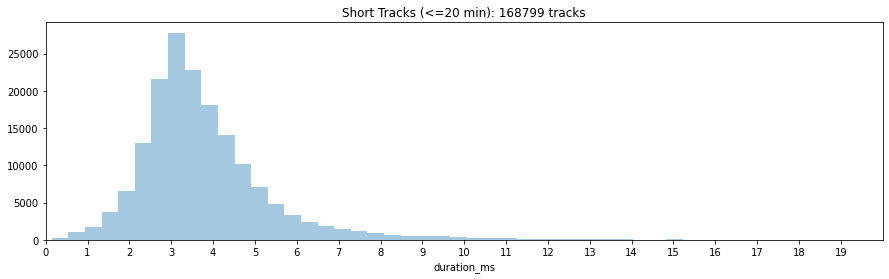

In [361]:
short_tracks = df.loc[df['duration_ms']<=20]
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(short_tracks['duration_ms'], kde = False)
ax.set_title(f'Short Tracks (<=20 min): {short_tracks.shape[0]} tracks')
ax.set_xticks(range(0,20,1))
ax.set_xlim(0,20)
plt.savefig('a_durationms.png')
plt.show()

#### Tempo

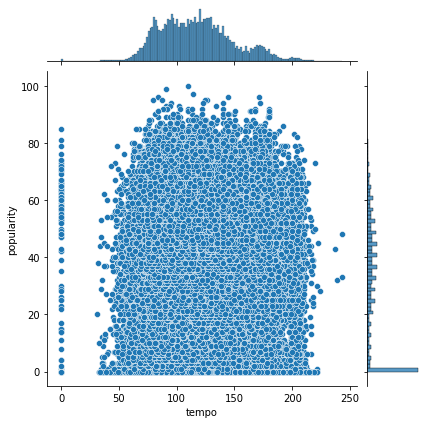

In [67]:
sns.jointplot(x='tempo', y='popularity', data=df)
plt.show()

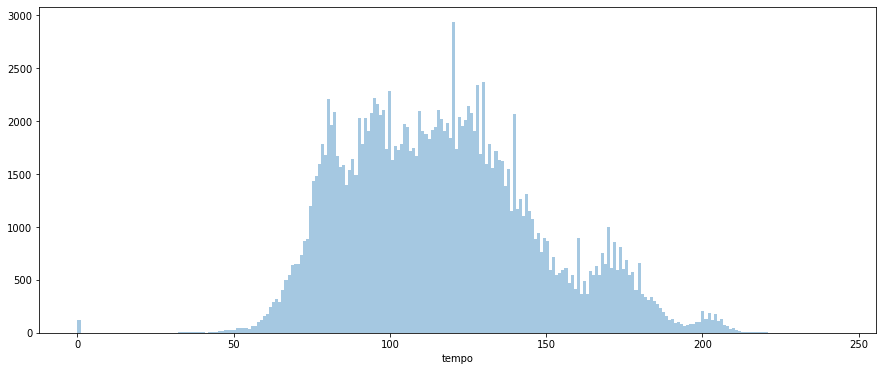

In [68]:
fig, ax = plt.subplots(figsize = (15, 6))
ax = sns.distplot(df['tempo'], bins=250, kde=False)

#### Target: Popularity
- 0값이 다수 존재

In [115]:
df['popularity'].value_counts()

0      27260
43      3109
44      3098
41      3063
40      3037
       ...  
94         4
93         4
99         1
97         1
100        1
Name: popularity, Length: 100, dtype: int64

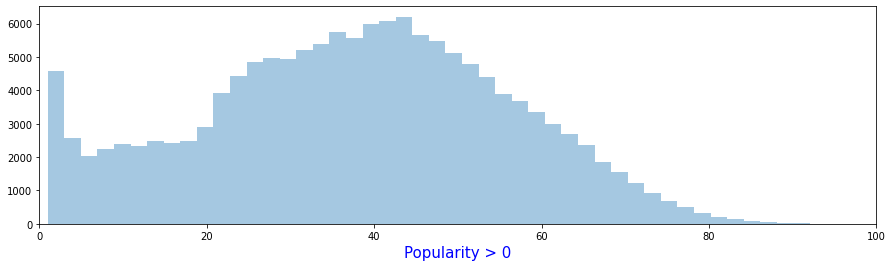

In [362]:
# 0값 제외한 분포 시각화

fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.distplot(df.loc[df['popularity']>0, 'popularity'], ax=ax, kde=False)
ax.set_xlim(0,100)
ax.set_xlabel('Popularity > 0', c='b', fontsize=15)

plt.savefig('a_target>0.png')
plt.show()

In [74]:
df.head(4)

valence  year  acousticness  ...    tempo  count      mean
0   0.0594  1921         0.982  ...   80.954      2  2.500000
1   0.9630  1921         0.732  ...   60.936      5  3.000000
2   0.0394  1921         0.961  ...  110.339     21  2.428571
3   0.1650  1921         0.967  ...  100.109      1  3.000000

[4 rows x 18 columns]

## Hold-out 교차검증
- 훈련/검증/테스트 셋으로 나눠서 검증

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169088 entries, 0 to 170652
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           169088 non-null  float64
 1   year              169088 non-null  int64  
 2   acousticness      169088 non-null  float64
 3   artists           169088 non-null  object 
 4   danceability      169088 non-null  float64
 5   duration_ms       169088 non-null  float64
 6   energy            169088 non-null  float64
 7   explicit          169088 non-null  int64  
 8   instrumentalness  169088 non-null  object 
 9   key               169088 non-null  int64  
 10  liveness          169088 non-null  float64
 11  loudness          169088 non-null  float64
 12  mode              169088 non-null  int64  
 13  popularity        169088 non-null  int64  
 14  speechiness       169088 non-null  float64
 15  tempo             169088 non-null  float64
 16  count             16

In [263]:
# df 새로 만들기
df2=df.drop(['year','artists', 'count', 'mean', 'explicit', 'loudness'], axis=1)
df2.columns

Index(['valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'mode', 'popularity',
       'speechiness', 'tempo', 'isExplicit', 'is_loud'],
      dtype='object')

-'year'가 주는 영향이 너무 큼

In [264]:
df2.head(5)

valence  acousticness  danceability  ...    tempo  isExplicit    is_loud
0   0.0594         0.982         0.279  ...   80.954          No     Mellow
1   0.9630         0.732         0.819  ...   60.936          No       Soft
2   0.0394         0.961         0.328  ...  110.339          No  Very Soft
3   0.1650         0.967         0.275  ...  100.109          No       Soft
4   0.2530         0.957         0.418  ...  101.665          No       Soft

[5 rows x 14 columns]



---



### 데이터셋 나누기

In [265]:
train, test = train_test_split(df2, test_size=0.2, random_state=2) #train/test
train, val = train_test_split(train, train_size=0.8, random_state=2) #train/val

print("train shape: ", train.shape)
print("val shape: ", val.shape)
print("test shape: ", test.shape)

train shape:  (108216, 14)
val shape:  (27054, 14)
test shape:  (33818, 14)


In [266]:
# 데이터를 훈련/테스트 데이터로 분리
target='popularity'

X_train=train.drop('popularity', axis=1)
y_train=train[target]

X_val=val.drop('popularity', axis=1)
y_val=val[target]

X_test=test.drop('popularity', axis=1)
y_test=test[target]

## Models

전처리 목록
- Explicit -> IsExplicit(Yes, NO)
- Loudness -> 이상치 제거, is_loud 5구간 분할함
- instrumentalness -> 3구간 분할함

In [268]:
#All linear
from sklearn.linear_model import LinearRegression
linear = make_pipeline(
    TargetEncoder(),
    StandardScaler(),
    LinearRegression()
)

linear.fit(X_train, y_train)

#평가지표
print('R^2', linear.score(X_val, y_val))

y_pred = linear.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'검증셋 에러: {mae:.2f}')

R^2 0.4565987431333031
검증셋 에러: 12.82


In [271]:
#All Randomforest
from sklearn.ensemble import RandomForestRegressor
RF = make_pipeline(
    TargetEncoder(),
    #StandardScaler(),영향 x
    RandomForestRegressor(random_state=2, n_jobs=-1, max_depth=10)
)

RF.fit(X_train, y_train)

#평가지표
print('R^2', RF.score(X_val, y_val))

y_pred = RF.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'검증셋 에러: {mae:.2f}')

R^2 0.5625829055293308
검증셋 에러: 10.90


- RandomForest 가장 설명력이 높고(56%), MAE가 10.90로 에러 수치가 낮음 -> 채택!

- 기준모델과의 비교결과 에러 수준을 낮췄다.
 - 기준모델 MAE: 18.49
 - RF: 10.90


### 순열 중요도 확인
- 피처를 선택하는데 도움받기 위해
- 0.5 이상인 피처만 선택하고 모델 재학습을 해보았으나, 설명력은 다소 낮아지고 별 차이 없는 것을 확인함
- 모든 피처를 선택하는 것으로 진행



---



## 하이퍼 파라미터 튜닝

- 모델 개선하기
- RandomSearchCV 활용
- SHAP에 적용하기 위해서 인코딩 후 CV 진행


In [283]:
encoder = TargetEncoder()
X_train_encoded = encoder.fit_transform(X_train,y_train) # 학습데이터
X_val_encoded = encoder.transform(X_val,y_val) # 검증데이터
X_test_encoded = encoder.transform(X_test,y_test) # 검증데이터

In [284]:
#shap 때문에 다시 함
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [10, 15, 20, None], 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=2),
    param_distributions=param_distributions, 
    n_iter=2, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=1, 
    return_train_score=True, 
    n_jobs=-1,
    random_state=2
)

search.fit(X_train_encoded, y_train);

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.9min finished


In [285]:
print('최적 하이퍼파라미터: ', search.best_params_)
print('MAE: ', -search.best_score_)

최적 하이퍼파라미터:  {'max_depth': 15, 'n_estimators': 122}
MAE:  10.663445123261626


- 검증 모델에 적용해보기

In [286]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옴
RF_t_serch = search.best_estimator_

In [287]:
#튜닝 후

from sklearn.metrics import mean_absolute_error

print('튜닝 후 R^2', RF_t_serch.score(X_val_encoded, y_val))
y_pred = RF_t_serch.predict(X_val_encoded)
mae = mean_absolute_error(y_val, y_pred)
print(f'튜닝 후 검증세트 MAE: {mae:,.3f}')

튜닝 후 R^2 0.5800669589509281
튜닝 후 검증세트 MAE: 10.643


In [288]:
#튜닝 전
print('튜닝 전 R^2', RF.score(X_val, y_val))
y_pred = RF.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'튜닝 전 검증세트 MAE: {mae:.3f}')

튜닝 전 R^2 0.5625829055293308
튜닝 전 검증세트 MAE: 10.899


- 하이퍼파라미터 튜닝으로 MAE 0.2 감소

## 최종 모델 test점수

In [289]:
#R^2
print(f'Test R^2: {RF_t_serch.score(X_test_encoded, y_test):,.3f}')

#MAE
y_pred = RF_t_serch.predict(X_test_encoded)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {mae:,.3f}')

#MSE
mse=mean_squared_error(y_test, y_pred)
print(f'Test MSE: {mse:,.3f}')

#RMSE
print(f'Test RMSE: {np.sqrt(mse):,.3f}')

Test R^2: 0.582
Test MAE: 10.678
Test MSE: 198.806
Test RMSE: 14.100


- 검증세트와 비슷한 결과
- 최종 모델 test 점수

## 머신러닝 모델 해석
- PDP
- SHAP

#### Shap summary plot
- 특성별로 특성 기여도의 크기를 비교해보고 특성값과 예측에 미치는 영향 사이의 관계를 알아보고자 함
- SHAP은 Pipeline을 지원하지 않기 때문에 위에 특성 그대로 다시 학습(train과 test에만 적용)

In [290]:
import shap

explainer = shap.TreeExplainer(RF_t_serch)

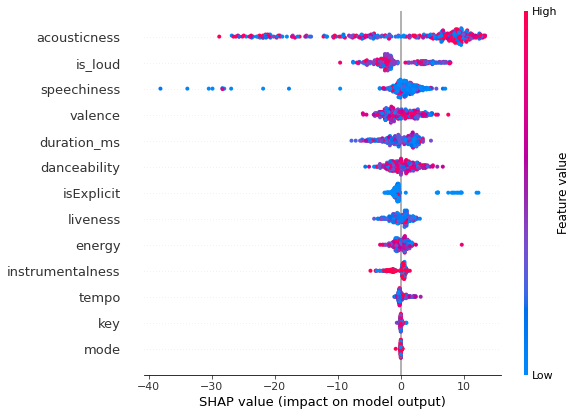

In [291]:
shap_values = explainer.shap_values(X_test_encoded.iloc[:300])
shap.summary_plot(shap_values, X_train_encoded.iloc[:300])

- acoutsicness는 각각 데이터에 평균적으로 크게 영향을 미침
- summary plot은 개략적으로 각 특성이 데이터에 어떤 영향을 미쳤는지 확인합니다. 점 하나하나는 각각의 데이터에 영향을 미친 정도입니다. 전체적으로 보면 위로갈 수록 평균적으로 크게 영향을 미친 것이고, 아래로내려갈 수록 작습니다. 


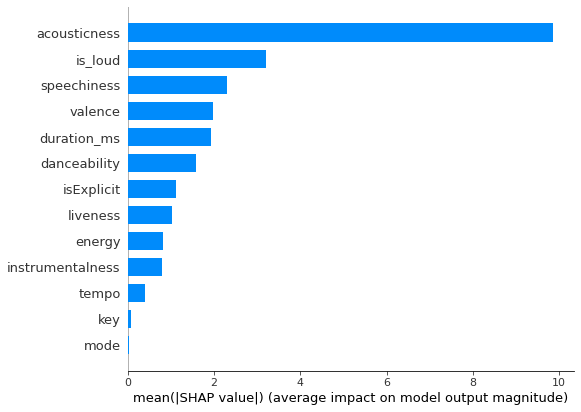

In [292]:
shap.summary_plot(shap_values, X_train_encoded.iloc[:300], plot_type="bar")

- 오디오 특성 중 acousticness가 인기도 예측에 영향을 많이 미치는 것을 볼 수 있음
- 어떻게 영향을 미치는 것일지 PDP로 확인해보기

### PDP

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


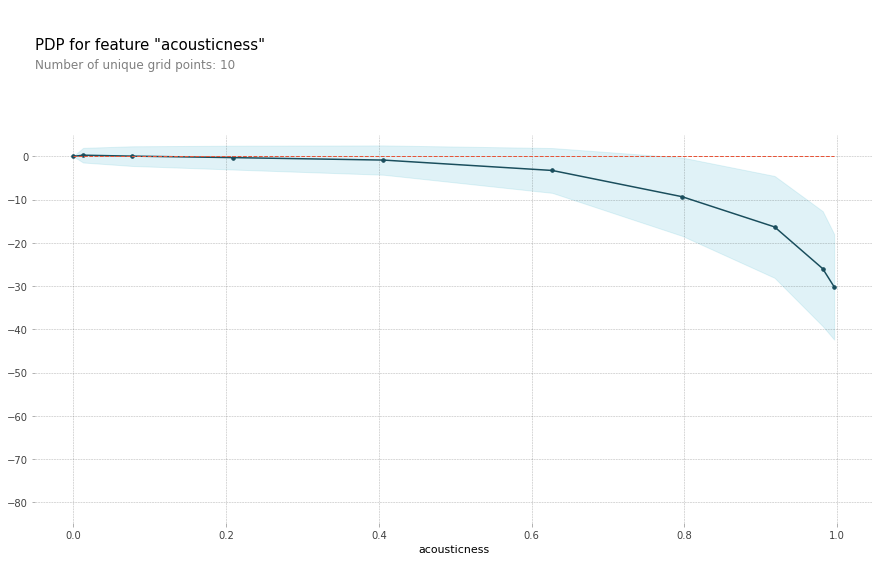

In [302]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='acousticness'

isolated = pdp_isolate(
    model=RF_t_serch,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

- acousticness는 인기도와 약한 음의 관계
- acousticness가 낮을 수록 인기도가 높아진다.

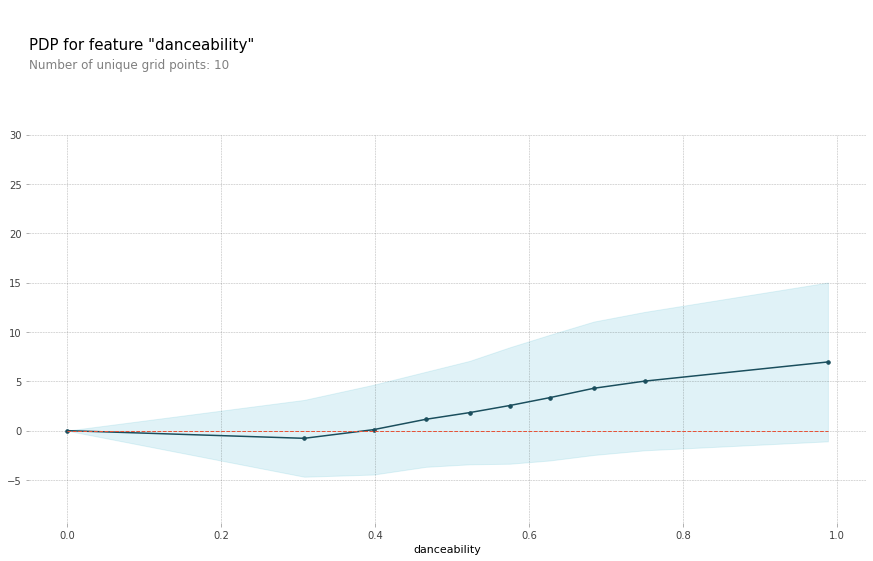

In [320]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='danceability'

isolated = pdp_isolate(
    model=RF_t_serch,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [327]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['acousticness', 'danceability']

interaction = pdp_interact(
    model=RF_t_serch, 
    dataset=X_train_encoded,
    model_features=X_train.columns, 
    features=features
)

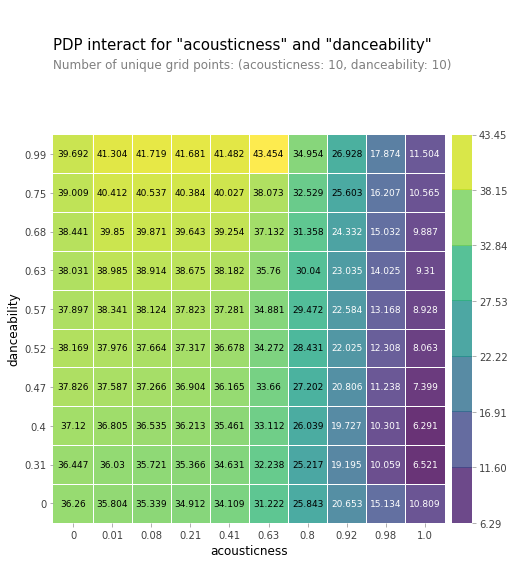

In [328]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

- 특성의 상호작용 중 가장 낮은 점수인 6.291점을 보면, acousticness가 1.0으로 높을 때, danceability가 0.31로 낮은 것을 볼 수 있음.

In [307]:
# test dataset의 96점 받은 데이터 예시
shap.initjs()

row = X_test_encoded.iloc[[19613]]
y_test[19613]

RF_t_serch.predict(row)

import shap

explainer = shap.TreeExplainer(RF_t_serch)
shap_values = explainer.shap_values(row)

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

- 인기도를 53점 받은 한 데이터를 예시로 보면, 1이 최대 점수인 acousticness이 0.1로 낮을 때( 덜  클래식 할 때) 인기도를 높은 것을 볼 수 있음
- danceability, is_loud, energy 등 신남의 정도는 다소 높은 것이 인기도를 높이는 데 영향을 준 것을 볼 수 있음



---

## 결과 정리



결론: 클래식함은 덜 하고, 리드미컬한 음악적 요소가 있을 때 인기도가 올라감
- 60%정도의 설명력을 가짐
- 차후 인기도에 영향을 주는 다른 요소들을 추가하여 분석한다면 설명력 높은 예측 모델을 만들 수 있을 것으로 보임


기대 효과
- 곡 발매 전, 인기도 테스트를 시도해볼 수 있음
스포티파이 오디오 특성 기준처럼 측정할 수 있는 도구 필요
- 작곡가가 대중성 있는 곡을 만든다고 할 때 가이드라인이 될 수 있음


한계
- 장르가 섞여 있는거라
대중가요에 좀 더 초점이 맞춰져 있음
- 클래식/대중 가요 이처럼 장르를 나눠서 인기도를 예측한다면 좀 더 설명력 있는 결과를 얻을 수 있을 듯함
- 인기도가 최근 음악 재생 수에 영향을 많이 받음
(최근 음악 중 인기도가 높은 곡의 음악적 요소가 모델에 영향을 많이 주었을 수 있음)